In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 128

In [3]:
file_name = 'wheat_40_var_avg_new.csv'

def dir(file_name):
    return '../data/'+file_name

In [4]:
def seperate_X_Y(dataframe):
    return (dataframe.drop('classes', axis =1), dataframe.loc[:,'classes'])

In [5]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3

FILT = 3
FILTER = filter_method(FILT).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = 1

#will be used for test dataset in msc
reference= None

In [6]:
from sklearn.model_selection import train_test_split
def create_test_train(X, y, test_size = 0.2, shuffle = True):
    return train_test_split(X,y, test_size = test_size, shuffle=shuffle)

In [7]:
#Standard Normal Variate
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [8]:
# Multiplicative scatter correction
def msc(input_data, reference=None):
#     print(reference)
    ''' Perform Multiplicative scatter correction'''

    # Baseline correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        matm = np.mean(input_data, axis=0)
    else:
        matm = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(matm, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 

    return (output_data, matm)

In [9]:
from scipy.signal import savgol_filter, general_gaussian
def savgol(input_data):
    w = WINDOW
    p = ORDER
    d = DERIVATIVE
    
    output_data = savgol_filter(np.array(input_data), w, polyorder = p, deriv=d)
    
    return output_data

In [10]:
def preprocess_data(X,y, type="train"):
    if FILTER == "snv":
        return {"X": snv(np.array(X)), "y": y}
    elif FILTER == "msc":
        msc_output = msc(np.array(X), reference = reference if type=="test" else None)
        X = msc_output[0]
        ref = msc_output[1]
        return {
            "X": X,
            "y": y,
            "ref": ref
        }
    elif FILTER == "savgol":
        return {
            "X": savgol(X),
            "y": y
        }
    else:
        return {
            "X":X,
            "y":y
        }

In [11]:
dataset = pd.read_csv(dir(file_name))
X,y = seperate_X_Y(dataset)

In [12]:
y_set = set(y)

In [13]:
NUM_OF_CLASSES = len(y_set)

In [14]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = create_test_train(X,y)

In [15]:
preprocessed_results = preprocess_data(X_train_raw,y_train_raw)
X_train, y_train = preprocessed_results["X"], preprocessed_results["y"]

if FILTER == "msc":
    reference = preprocessed_results["ref"]
    
preprocessed_results_test = preprocess_data(X_test_raw, y_test_raw, type="test")
X_test, y_test = preprocessed_results_test["X"], preprocessed_results_test["y"]

In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)

(64512, 147, 1)
(16128, 147, 1)


In [17]:
import keras
from keras import Sequential
from keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D

In [18]:
def createModel(input_shape,num_classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=5 ))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    
    return model

In [19]:
model = createModel(X_train.shape[1:],NUM_OF_CLASSES)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 28, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense (Dense)               (None, 1000)              897000    
                                                                 
 dense_1 (Dense)             (None, 4)                 4004      
                                                                 
Total params: 901,196
Trainable params: 901,196
Non-trainable params: 0
__________________________________________________

In [21]:
train_eva = []
test_eva = []

In [22]:
history_dataframe = pd.DataFrame() 

In [23]:
from IPython.display import clear_output

for x in range(400):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))
    
#     clear_output(wait=True)


Epoch:  1
504/504 - 20s - loss: 1.1892 - accuracy: 0.4350 - 20s/epoch - 39ms/step
for training
2016/2016 [==============================] - 21s 10ms/step - loss: 1.0950 - accuracy: 0.5378
for testing
504/504 [==============================] - 5s 9ms/step - loss: 1.0907 - accuracy: 0.5387

Epoch:  2
504/504 - 21s - loss: 0.9751 - accuracy: 0.6051 - 21s/epoch - 41ms/step
for training
2016/2016 [==============================] - 15s 7ms/step - loss: 0.8342 - accuracy: 0.6628
for testing
504/504 [==============================] - 4s 7ms/step - loss: 0.8365 - accuracy: 0.6618

Epoch:  3
504/504 - 15s - loss: 0.7250 - accuracy: 0.6937 - 15s/epoch - 30ms/step
for training
2016/2016 [==============================] - 15s 8ms/step - loss: 0.6543 - accuracy: 0.7185
for testing
504/504 [==============================] - 4s 8ms/step - loss: 0.6546 - accuracy: 0.7177

Epoch:  4
504/504 - 15s - loss: 0.6149 - accuracy: 0.7397 - 15s/epoch - 31ms/step
for training
2016/2016 [=========================

for training
2016/2016 [==============================] - 15s 7ms/step - loss: 0.2007 - accuracy: 0.9231
for testing
504/504 [==============================] - 4s 7ms/step - loss: 0.2029 - accuracy: 0.9237

Epoch:  30
504/504 - 14s - loss: 0.2061 - accuracy: 0.9199 - 14s/epoch - 29ms/step
for training
2016/2016 [==============================] - 15s 7ms/step - loss: 0.1949 - accuracy: 0.9264
for testing
504/504 [==============================] - 4s 7ms/step - loss: 0.1961 - accuracy: 0.9255

Epoch:  31
504/504 - 17s - loss: 0.2008 - accuracy: 0.9227 - 17s/epoch - 33ms/step
for training
2016/2016 [==============================] - 15s 7ms/step - loss: 0.1896 - accuracy: 0.9286
for testing
504/504 [==============================] - 4s 7ms/step - loss: 0.1922 - accuracy: 0.9281

Epoch:  32
504/504 - 15s - loss: 0.2016 - accuracy: 0.9218 - 15s/epoch - 30ms/step
for training
2016/2016 [==============================] - 15s 8ms/step - loss: 0.2021 - accuracy: 0.9232
for testing
504/504 [====

2016/2016 [==============================] - 15s 7ms/step - loss: 0.1353 - accuracy: 0.9505
for testing
504/504 [==============================] - 4s 7ms/step - loss: 0.1383 - accuracy: 0.9502

Epoch:  58
504/504 - 16s - loss: 0.1499 - accuracy: 0.9446 - 16s/epoch - 31ms/step
for training
2016/2016 [==============================] - 14s 7ms/step - loss: 0.1390 - accuracy: 0.9482
for testing
504/504 [==============================] - 3s 6ms/step - loss: 0.1419 - accuracy: 0.9453

Epoch:  59
504/504 - 15s - loss: 0.1542 - accuracy: 0.9425 - 15s/epoch - 30ms/step
for training
2016/2016 [==============================] - 14s 7ms/step - loss: 0.1427 - accuracy: 0.9467
for testing
504/504 [==============================] - 4s 7ms/step - loss: 0.1453 - accuracy: 0.9448

Epoch:  60
504/504 - 13s - loss: 0.1512 - accuracy: 0.9431 - 13s/epoch - 26ms/step
for training
2016/2016 [==============================] - 13s 6ms/step - loss: 0.1470 - accuracy: 0.9451
for testing
504/504 [=================

504/504 [==============================] - 2s 4ms/step - loss: 0.1326 - accuracy: 0.9503

Epoch:  86
504/504 - 12s - loss: 0.1301 - accuracy: 0.9518 - 12s/epoch - 24ms/step
for training
2016/2016 [==============================] - 12s 6ms/step - loss: 0.1333 - accuracy: 0.9501
for testing
504/504 [==============================] - 4s 8ms/step - loss: 0.1393 - accuracy: 0.9487

Epoch:  87
504/504 - 16s - loss: 0.1243 - accuracy: 0.9545 - 16s/epoch - 32ms/step
for training
2016/2016 [==============================] - 17s 9ms/step - loss: 0.1139 - accuracy: 0.9582
for testing
504/504 [==============================] - 2s 5ms/step - loss: 0.1173 - accuracy: 0.9566

Epoch:  88
504/504 - 16s - loss: 0.1260 - accuracy: 0.9528 - 16s/epoch - 31ms/step
for training
2016/2016 [==============================] - 12s 6ms/step - loss: 0.1239 - accuracy: 0.9539
for testing
504/504 [==============================] - 3s 6ms/step - loss: 0.1291 - accuracy: 0.9520

Epoch:  89
504/504 - 14s - loss: 0.1262 

504/504 [==============================] - 2s 4ms/step - loss: 0.1040 - accuracy: 0.9633

Epoch:  114
504/504 - 11s - loss: 0.1166 - accuracy: 0.9564 - 11s/epoch - 22ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.0977 - accuracy: 0.9643
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.1044 - accuracy: 0.9640

Epoch:  115
504/504 - 11s - loss: 0.1104 - accuracy: 0.9597 - 11s/epoch - 22ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.1148 - accuracy: 0.9570
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.1202 - accuracy: 0.9557

Epoch:  116
504/504 - 11s - loss: 0.1104 - accuracy: 0.9606 - 11s/epoch - 22ms/step
for training
2016/2016 [==============================] - 9s 4ms/step - loss: 0.1014 - accuracy: 0.9634
for testing
504/504 [==============================] - 3s 7ms/step - loss: 0.1077 - accuracy: 0.9611

Epoch:  117
504/504 - 13s - loss: 0.1077

504/504 [==============================] - 2s 4ms/step - loss: 0.1012 - accuracy: 0.9641

Epoch:  142
504/504 - 13s - loss: 0.0952 - accuracy: 0.9655 - 13s/epoch - 26ms/step
for training
2016/2016 [==============================] - 10s 5ms/step - loss: 0.0855 - accuracy: 0.9698
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0923 - accuracy: 0.9669

Epoch:  143
504/504 - 12s - loss: 0.0944 - accuracy: 0.9655 - 12s/epoch - 24ms/step
for training
2016/2016 [==============================] - 9s 4ms/step - loss: 0.0879 - accuracy: 0.9688
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0966 - accuracy: 0.9656

Epoch:  144
504/504 - 14s - loss: 0.0936 - accuracy: 0.9664 - 14s/epoch - 28ms/step
for training
2016/2016 [==============================] - 9s 4ms/step - loss: 0.0917 - accuracy: 0.9673
for testing
504/504 [==============================] - 2s 5ms/step - loss: 0.0980 - accuracy: 0.9646

Epoch:  145
504/504 - 12s - loss: 0.098

504/504 [==============================] - 2s 4ms/step - loss: 0.0864 - accuracy: 0.9684

Epoch:  170
504/504 - 11s - loss: 0.0857 - accuracy: 0.9683 - 11s/epoch - 21ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.0917 - accuracy: 0.9663
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.1016 - accuracy: 0.9622

Epoch:  171
504/504 - 11s - loss: 0.0852 - accuracy: 0.9693 - 11s/epoch - 21ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.0864 - accuracy: 0.9685
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0966 - accuracy: 0.9639

Epoch:  172
504/504 - 11s - loss: 0.0861 - accuracy: 0.9685 - 11s/epoch - 22ms/step
for training
2016/2016 [==============================] - 9s 4ms/step - loss: 0.0827 - accuracy: 0.9701
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0913 - accuracy: 0.9670

Epoch:  173
504/504 - 11s - loss: 0.0824

504/504 [==============================] - 2s 4ms/step - loss: 0.0902 - accuracy: 0.9666

Epoch:  198
504/504 - 11s - loss: 0.0748 - accuracy: 0.9729 - 11s/epoch - 21ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.0691 - accuracy: 0.9759
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0810 - accuracy: 0.9715

Epoch:  199
504/504 - 11s - loss: 0.0775 - accuracy: 0.9726 - 11s/epoch - 21ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.0768 - accuracy: 0.9716
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0867 - accuracy: 0.9688

Epoch:  200
504/504 - 11s - loss: 0.0773 - accuracy: 0.9719 - 11s/epoch - 21ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.0792 - accuracy: 0.9718
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0898 - accuracy: 0.9685

Epoch:  201
504/504 - 11s - loss: 0.0761

504/504 [==============================] - 2s 4ms/step - loss: 0.0800 - accuracy: 0.9720

Epoch:  226
504/504 - 11s - loss: 0.0702 - accuracy: 0.9753 - 11s/epoch - 21ms/step
for training
2016/2016 [==============================] - 10s 5ms/step - loss: 0.0704 - accuracy: 0.9755
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0811 - accuracy: 0.9710

Epoch:  227
504/504 - 11s - loss: 0.0687 - accuracy: 0.9759 - 11s/epoch - 22ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.0640 - accuracy: 0.9772
for testing
504/504 [==============================] - 3s 5ms/step - loss: 0.0763 - accuracy: 0.9729

Epoch:  228
504/504 - 12s - loss: 0.0681 - accuracy: 0.9757 - 12s/epoch - 24ms/step
for training
2016/2016 [==============================] - 9s 4ms/step - loss: 0.0820 - accuracy: 0.9688
for testing
504/504 [==============================] - 2s 5ms/step - loss: 0.0899 - accuracy: 0.9661

Epoch:  229
504/504 - 12s - loss: 0.070

504/504 [==============================] - 2s 4ms/step - loss: 0.0687 - accuracy: 0.9752

Epoch:  254
504/504 - 11s - loss: 0.0629 - accuracy: 0.9780 - 11s/epoch - 23ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.0555 - accuracy: 0.9807
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0682 - accuracy: 0.9763

Epoch:  255
504/504 - 11s - loss: 0.0671 - accuracy: 0.9758 - 11s/epoch - 22ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.0622 - accuracy: 0.9780
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0751 - accuracy: 0.9748

Epoch:  256
504/504 - 11s - loss: 0.0636 - accuracy: 0.9774 - 11s/epoch - 21ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.0521 - accuracy: 0.9818
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0630 - accuracy: 0.9785

Epoch:  257
504/504 - 11s - loss: 0.0635

504/504 [==============================] - 4s 7ms/step - loss: 0.0607 - accuracy: 0.9781

Epoch:  282
504/504 - 15s - loss: 0.0614 - accuracy: 0.9780 - 15s/epoch - 29ms/step
for training
2016/2016 [==============================] - 15s 7ms/step - loss: 0.0565 - accuracy: 0.9801
for testing
504/504 [==============================] - 4s 8ms/step - loss: 0.0704 - accuracy: 0.9752

Epoch:  283
504/504 - 15s - loss: 0.0614 - accuracy: 0.9780 - 15s/epoch - 30ms/step
for training
2016/2016 [==============================] - 15s 7ms/step - loss: 0.0612 - accuracy: 0.9776
for testing
504/504 [==============================] - 4s 7ms/step - loss: 0.0709 - accuracy: 0.9743

Epoch:  284
504/504 - 15s - loss: 0.0579 - accuracy: 0.9788 - 15s/epoch - 30ms/step
for training
2016/2016 [==============================] - 15s 7ms/step - loss: 0.0557 - accuracy: 0.9802
for testing
504/504 [==============================] - 4s 7ms/step - loss: 0.0691 - accuracy: 0.9749

Epoch:  285
504/504 - 15s - loss: 0.0

504/504 [==============================] - 4s 8ms/step - loss: 0.0591 - accuracy: 0.9798

Epoch:  310
504/504 - 15s - loss: 0.0556 - accuracy: 0.9801 - 15s/epoch - 30ms/step
for training
2016/2016 [==============================] - 16s 8ms/step - loss: 0.0457 - accuracy: 0.9841
for testing
504/504 [==============================] - 4s 8ms/step - loss: 0.0591 - accuracy: 0.9798

Epoch:  311
504/504 - 15s - loss: 0.0565 - accuracy: 0.9798 - 15s/epoch - 31ms/step
for training
2016/2016 [==============================] - 19s 9ms/step - loss: 0.0569 - accuracy: 0.9795
for testing
504/504 [==============================] - 5s 10ms/step - loss: 0.0733 - accuracy: 0.9737

Epoch:  312
504/504 - 20s - loss: 0.0571 - accuracy: 0.9795 - 20s/epoch - 40ms/step
for training
2016/2016 [==============================] - 17s 8ms/step - loss: 0.0516 - accuracy: 0.9817
for testing
504/504 [==============================] - 4s 8ms/step - loss: 0.0655 - accuracy: 0.9769

Epoch:  313
504/504 - 15s - loss: 0.

504/504 [==============================] - 4s 8ms/step - loss: 0.0560 - accuracy: 0.9804

Epoch:  338
504/504 - 16s - loss: 0.0522 - accuracy: 0.9819 - 16s/epoch - 31ms/step
for training
2016/2016 [==============================] - 16s 8ms/step - loss: 0.0533 - accuracy: 0.9814
for testing
504/504 [==============================] - 4s 8ms/step - loss: 0.0670 - accuracy: 0.9761

Epoch:  339
504/504 - 16s - loss: 0.0524 - accuracy: 0.9811 - 16s/epoch - 32ms/step
for training
2016/2016 [==============================] - 15s 7ms/step - loss: 0.0444 - accuracy: 0.9846
for testing
504/504 [==============================] - 4s 7ms/step - loss: 0.0591 - accuracy: 0.9790

Epoch:  340
504/504 - 16s - loss: 0.0505 - accuracy: 0.9821 - 16s/epoch - 31ms/step
for training
2016/2016 [==============================] - 15s 8ms/step - loss: 0.0480 - accuracy: 0.9829
for testing
504/504 [==============================] - 4s 8ms/step - loss: 0.0603 - accuracy: 0.9787

Epoch:  341
504/504 - 15s - loss: 0.0

504/504 [==============================] - 2s 5ms/step - loss: 0.0510 - accuracy: 0.9829

Epoch:  366
504/504 - 14s - loss: 0.0509 - accuracy: 0.9817 - 14s/epoch - 29ms/step
for training
2016/2016 [==============================] - 11s 5ms/step - loss: 0.0529 - accuracy: 0.9800
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0659 - accuracy: 0.9766

Epoch:  367
504/504 - 13s - loss: 0.0484 - accuracy: 0.9828 - 13s/epoch - 25ms/step
for training
2016/2016 [==============================] - 9s 5ms/step - loss: 0.0411 - accuracy: 0.9851
for testing
504/504 [==============================] - 3s 5ms/step - loss: 0.0568 - accuracy: 0.9801

Epoch:  368
504/504 - 13s - loss: 0.0495 - accuracy: 0.9823 - 13s/epoch - 27ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.0429 - accuracy: 0.9851
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0560 - accuracy: 0.9802

Epoch:  369
504/504 - 11s - loss: 0.048

504/504 [==============================] - 2s 4ms/step - loss: 0.0749 - accuracy: 0.9732

Epoch:  394
504/504 - 11s - loss: 0.0463 - accuracy: 0.9837 - 11s/epoch - 22ms/step
for training
2016/2016 [==============================] - 9s 5ms/step - loss: 0.0479 - accuracy: 0.9838
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0611 - accuracy: 0.9790

Epoch:  395
504/504 - 11s - loss: 0.0493 - accuracy: 0.9823 - 11s/epoch - 22ms/step
for training
2016/2016 [==============================] - 11s 5ms/step - loss: 0.0425 - accuracy: 0.9847
for testing
504/504 [==============================] - 5s 9ms/step - loss: 0.0560 - accuracy: 0.9800

Epoch:  396
504/504 - 12s - loss: 0.0484 - accuracy: 0.9833 - 12s/epoch - 23ms/step
for training
2016/2016 [==============================] - 8s 4ms/step - loss: 0.0470 - accuracy: 0.9826
for testing
504/504 [==============================] - 2s 4ms/step - loss: 0.0639 - accuracy: 0.9774

Epoch:  397
504/504 - 11s - loss: 0.045

In [24]:
history_dataframe

,loss,accuracy
0,1.189218,0.435004
1,0.975108,0.605066
2,0.724955,0.693700
3,0.614860,0.739676
4,0.545470,0.775561
...,...,...
395,0.048405,0.983305
396,0.045910,0.983801
397,0.048493,0.982701
398,0.045375,0.984034


In [25]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

In [26]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

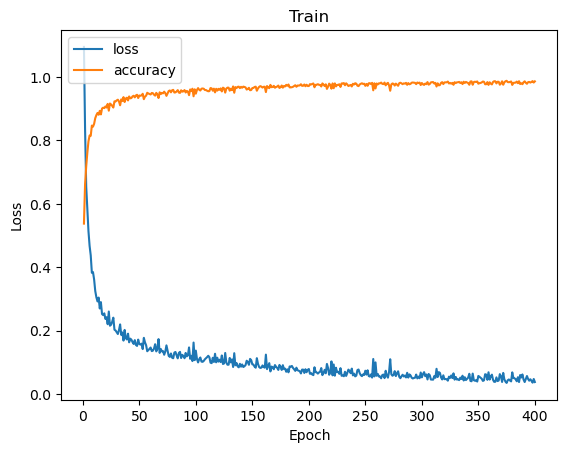

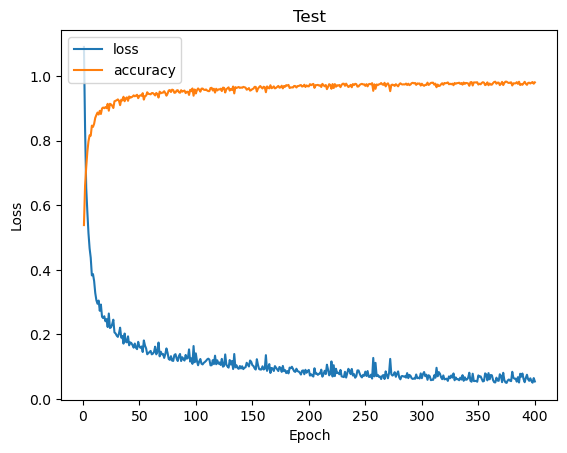

In [27]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])